In [16]:

from exif import Image #Used for checking image data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os #For file sorting
import cv2 #openCV
import imutils #i forgor
from skimage.draw import line as skiLine #Prevents line clashing with normal line
from scipy.fft import irfft2, fftshift, irfft #IFT imports
plt.rcParams.update({'font.size': 50})

In [17]:
path="images/water1/" #Folder where images are
photos = [] #Array for filepaths
for filename in os.listdir(path):
    my_source = path + filename
    photos.append(my_source) #Adds the filepath of the image to an array
    
photos.sort() #Sorts the photos by time taken

In [18]:
seps = []
freq = []
ratio = 14392.0437 #Ratio of pixels per metre
density = 998.2 #Density of solution
i = 140 #Starting frequency

#Finds the separation values of each pattern, as well as draws a line to visualise each plot
for filename in photos:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (93, 93), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    
    #Find maxima in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #Centre of central maxima
    M = cv2.moments(cnts[int(len(cnts)/2)]) 
    if M["m00"] != 0:
        startX = int(M["m10"] / M["m00"])
        startY = int(M["m01"] / M["m00"])
    else:
        startX = 0
        startY = 0
    
    #Centre of maxima next to central maxima
    N = cv2.moments(cnts[int(len(cnts)/2) - 1])
    if N["m00"] != 0:
        endX = int(N["m10"] / N["m00"])
        endY = int(N["m01"] / N["m00"])
    else:
        endX = 0
        endY = 0
    
    #Separation using pythag 
    separation = np.sqrt((endY - startY)**2 + (endX - startX)**2)/ratio
    cv2.line(image, (startX, startY), (endX, endY), (0, 255, 0), thickness=2) #Paint line on image
    cv2.imwrite("images/lines/" + str(i) + "_Line.jpeg", image) #Save image with the line
    seps.append(separation * 2) #Put separation value into array
    freq.append(i) #Appends frequency to array
    
    i += 10

print(seps)


[0.017518495455173665, 0.019185316793247167, 0.020995316846917977, 0.022250135396268075, 0.023777753089950716, 0.025027713366051495, 0.026138847857003617, 0.02683333177001658, 0.027666735296785126, 0.028500161666679836, 0.029060110764393254, 0.029893450546675086, 0.03045378051598207, 0.0311481560631935, 0.03170367078660096, 0.032675850030089944, 0.03338069950264065, 0.03449149213167637, 0.03322703758682812, 0.033504850783461756]


In [19]:
length = 2.583
deltaL = 0.001
deltaD = 2/ratio
hVal = 0.15
deltaH = 0.001414213562
laserLambda = 0.000000633
kval = (np.pi * hVal * pd.Series(seps))/(laserLambda * (hVal**2 + length**2))*0.001
omega = 2 * np.pi * pd.Series(freq)*0.001

deltaKfromL = (pd.Series(seps) * hVal * 2 * length) * (1/((hVal**2 + length**2)**2)) * deltaL #DeltaK from length
deltaKfromD = hVal * (1/(hVal**2 + length**2)) * deltaD #DeltaK from separations
deltaKfromH = (pd.Series(seps)) * (length**2 - hVal**2) *(1/((hVal**2 + length**2)**2)) * deltaH #DeltaK from height calc

deltaK = (np.pi/laserLambda) * (deltaKfromL + deltaKfromD + deltaKfromH)*0.001 #Uncertainty in k
deltaKCube = 3*(kval ** 2) * deltaK #Uncertainty in k cube

omegasq = omega ** 2
kcube = kval ** 3

71026.1948882801 +- 3449.2430364515953


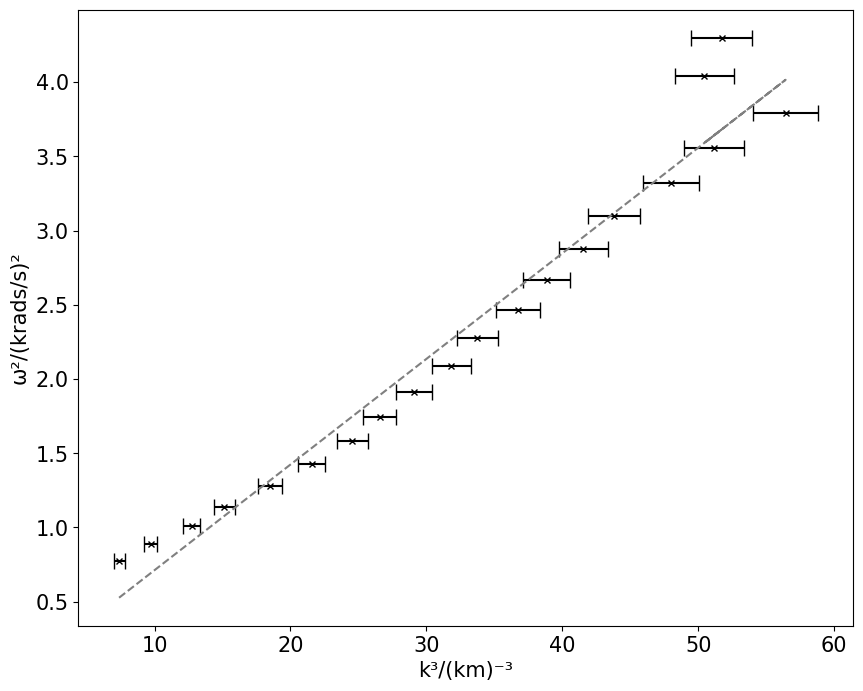

In [20]:
plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('k³/(km)⁻³')
ax.set_ylabel('ω²/(krads/s)²')

def line(x, slope, intercept):
    return slope*x + intercept

# Next few line, fits a line to the (x data, and y data)
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(slope * density * 1000,"+-",err_slope*density * 1000)

ax.errorbar( kcube,           
             omegasq,
             xerr = deltaKCube,
             marker='x',             
             markersize = 4,
             markerfacecolor = 'black',
             color='black',         
             linestyle='none',       
             capsize=6,              
           )

ax.plot(kcube, kcube*slope+intercept, 
         linestyle='--',
         color='gray',
       )


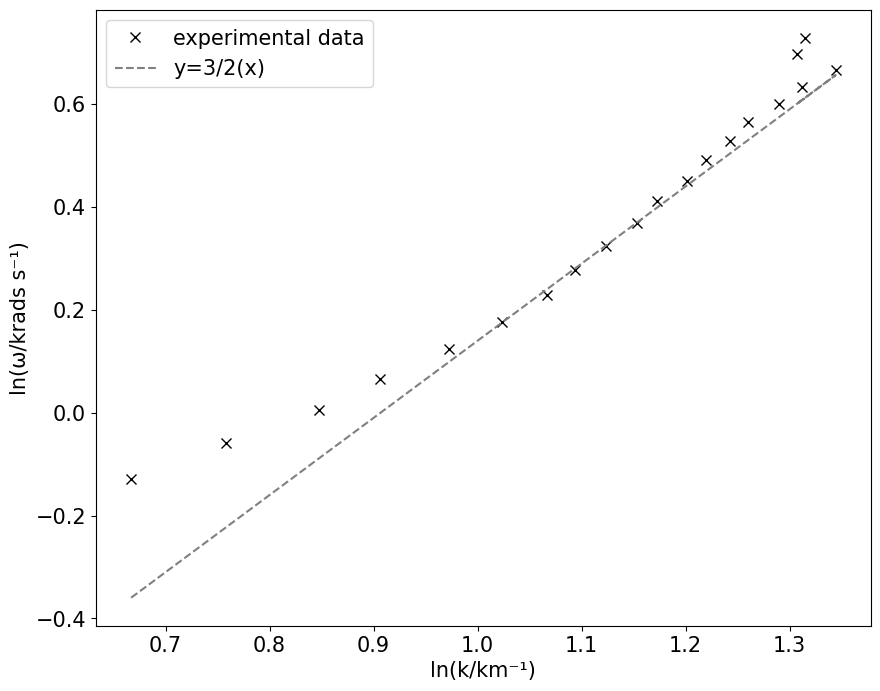

In [61]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('ln(k/km⁻¹)')
ax.set_ylabel('ln(ω/krads s⁻¹)')
ax.plot(     np.log(kval),           
             np.log(omega),
             marker='x',             
             markersize = 7,
             markerfacecolor = 'black',
             color='black',          
             linestyle='none',
             label='experimental data'
           )
ax.plot(     np.log(kval),           
             3/2*(np.log(kval))-1.360,
             marker='none',             
             markersize = 4,
             markerfacecolor = 'none',
             color='gray',          
             linestyle='--',
             label='y=3/2(x)'
             )
plt.legend()